In [65]:
import pandas as pd
import numpy as np
from datetime import datetime
import os, time, gc, datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from boruta import BorutaPy
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tools import *
from pyod.utils.utility import precision_n_scores
import xgboost as xgb
from xgboost import XGBClassifier

## Introduction

Feature  selection  plays  a  significant  role  in  improving  the performance of the machine learning algorithms in terms of reducing the time to build the learning model and increasing the  accuracy  in  the  learning  process. Hence it's important to pay more attention on the feature selection to enhance the performance of the machine learning algorithms. Identifying  the  suitable  feature selection method is very essential for a given machine learning task with high-dimensional data. The feature selection methods can be divided into 3 major categories. 

1. **Filter based methods** where we can specify some metric and based on that filter features (Pearson Correlation or Chi-square) 
2. **Wrapper based methods** consider the selection of a set of features as a search problem (Recursive Feature Elimination, Boruta)
3. **Embedded methods** use algorithms that have built-in feature selection methods (Random Forest, XGboost, LGBM)


**Random Forest**  algorithm is used for regression and classification problems, making it a diverse model. It prevents overfitting of data and fast to train with test data. But on the other hand, it is slow in creating predictions once model is made and must beware of outliers/holes in the data.

**XGboost** algorithm stands for eXtreme Gradient Boosting refers to the engineering goal to push the limit of computations resources for boosted tree algorithms. It can be used to solve regression, classification, ranking, and user-defined prediction problems.

**LightGBM** algorithm is a fast distributed as well as high-performance gradient boosting framework that makes the use of a learning algorithm that is tree-based, and is used for ranking, classification as well as many other machine learning tasks. It is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. LGBM has faster training speed and higher efficiency, lower memory usage, better accuracy than any other boosting algorithm, compatibility with Large Datasets, supports parallel and GPU learning.


#### We are going to focus mostly on Wrapper and Embedded methods in order to see which one works more efficient. 

In [66]:
def load_data():
    
    train_transaction = pd.read_csv("../data/train_transaction.csv") 
    train_identity = pd.read_csv("../data/train_identity.csv")  
    data=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
    
    return data

In [67]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [68]:
data = load_data()
data=reduce_mem_usage(data)

Mem. usage decreased to 650.48 Mb (66.8% reduction)


In [69]:
#Removing all V columns 

V_cols = [x for x in data.columns if x[0] == 'V']
data = data.drop(columns = V_cols, axis = 1)

print(data.shape)

(590540, 95)


In [70]:
#Removing all ID columns 

data = data.drop(columns = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
                 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
                 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
                 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'], axis = 1)

print(data.shape)


(590540, 57)


### Missing Values

1. **Deleting Rows:** When we completely remove the data with missing values results to highly accurate model. Therefore, deleting a particular row or column with no specific information is better. On the other hand, we get loss of information and data. This method does not work well if the percentage of missing values is high compared to the whole dataset. This method is good to apply when there are enough samples in the dataset. 
2. **Replacing with Mean/Median/Mode:** This method is a good solution when the data size is small and it can prevent data loss which results in removal of the rows and columns. But on the other hand, imputing the approximations add variance/bias and it does not work well to other multiple-imputations method. This strategy can be applied on a features which has numeric data.
3. **Assigning unique Category:** This method is suitable particularly for features which has categorical data. In this case when we have low variance after one hot encoding and it prevents the loss of data by adding an unique category. But disadvantage is that it adds less variance and adds another feature to the model while encoding, which may result in poor performance.
4. **Predicting Missing Values:** In this method we can use the features which do not have missing values and then predict the nulls with the help of a machine learning algorithm (for example linear regression). This method can result in better accuracy, unless a missing value is expected to have a very high variance. But problem with this method is that bias also arises when an incomplete conditioning set is used for a categorical variable and it considered only as a proxy for the true values.
5. **Use Algorithms supporting Missing Values:** This method does not require creation of a predictive model for each attribute with missing data in the dataset. For example, KNN is a machine learning algorithm which works on the principle of distance measure. This algorithm can be used when there are nulls present in the dataset. While the algorithm is applied, KNN considers the missing values by taking the majority of the K nearest values. Another possible algorithm to use is Random Forest. This model also produces a good result because it works well on non-linear and the categorical data. RF adapts to the data structure taking into consideration of the high variance or the bias, producing better results on large datasets. But good to mention that using these algorithms supporting missing valuesd is a very time consuming process and it can be critical in data mining where large databases are being extracted.
6. **Replacing with Zero:** Depending on where your data are coming from, a missing value may be better represented by the number zero. Replacing missing values with zeros is accomplished similar to the above method; just replace the mean function with zero.
7. **Replacing with Most Common or “Unknown” Class:** For categorical features, using mean, median, or zero-imputation doesn't make sense. Therefore, there are two ways to handle with categorical features. One approach is to replace missing values with the most common class and second approach is just replace missing values with a value like “Unknown” (similar to imputation a missing numeric feature with zeros).

**In order to handle missing values for our dataset, for categorical features we will replace missing values with the most frequent, and for numerical features we will do imputation of missing values by mean.** 

In [71]:
# Handling missing value

from sklearn.impute import SimpleImputer

num_cols = pd.read_csv("../data/corr_mat.csv").columns.to_list()[1:]
cat_cols = [_ for _ in data.columns if _ not in num_cols]
num_cols=[_ for _ in data.columns if _ not in cat_cols]

print('imputation of missing values by most') ; st=time.time()
imp = SimpleImputer( strategy='most_frequent')
imp.fit(data[cat_cols])
data[cat_cols] = imp.transform(data[cat_cols])
    
print('imputation of missing values by mean') ; st=time.time()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
data[num_cols] = imp.fit_transform(data[num_cols].replace(np.inf, 99999).values)

print(time.time()-st,'s')

#imp.fit(data[num_cols]) data[num_cols] = imp.transform(data[num_cols])

imputation of missing values by most
imputation of missing values by mean
2.710088014602661 s


In [72]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
data['Date']

0        2017-12-02 00:00:00
1        2017-12-02 00:00:01
2        2017-12-02 00:01:09
3        2017-12-02 00:01:39
4        2017-12-02 00:01:46
                 ...        
590535   2018-06-01 23:57:27
590536   2018-06-01 23:57:29
590537   2018-06-01 23:57:59
590538   2018-06-01 23:58:08
590539   2018-06-01 23:58:51
Name: Date, Length: 590540, dtype: datetime64[ns]

### Encoding categorical variables

1. **Replace or Custom Mapping** is useful for ordinal variable where the order of categories is important. If we want to make sure that the learning algorithm interprets the ordinal variables correctly, we can map the categorical values to integer values manually. In order to do that there are two ways, one is to use map function and another is to use replace function.
2. **Label Encoding** method transform non-numerical labels into numerical labels. Each category is assigned a unique label starting from 0. Label encoders are suitable for encoding variables where alphabetical alignment or numerical value of labels is important. 
3. **OneHot encoding** is the most widely used encoding scheme. It works by creating a column for each category present in the feature and assigning a 1 or 0 to indicate the presence of a category in the data. Onehot encoding performs better when the category cardinality of a feature is not too high. Because for feature with high cardinality, one hot encoding would create a large number of columns which could lead to memory problems.  
4. **Binary encoding** Binary encoding is not as intuitive as the approaches above. In this method the categories are encoded as ordinal. For example red, yellow, green categories are assigned labels as 1, 2, 3. For the next step these integers are converting into binary code (for example 1 becomes 001 and 2 becomes 010). Then the digits from that binary string are spliting into separate columns. Binary encoding is good for high cardinality data as it creates very few new columns. Most similar values overlap with each other across many of the new columns. This allows many machine learning algorithms to learn the similarity of the values.

#### In order to do encoding of our categorical variables, we will use Label Encoding method because it's the most suitable for out dataset.

In [73]:
#Label encoding

number = LabelEncoder()
for i in data.columns:
    if (data[i].dtype == 'object' or 'category' in str(data[i].dtype)):
        data[i] = number.fit_transform(data[i].astype('str'))

In [74]:
d1 = datetime.datetime(2018, 5, 1)
train_X = data[data['Date']<d1]
test_X = data[data['Date']>= d1]


y_train = train_X['isFraud'].copy()
conta = sum(y_train) / len(y_train)
X_train  = train_X.drop(columns = ['Date', 'isFraud'], axis = 1)

X_test1 = test_X.drop('Date', axis = 1)
X_test = test_X.drop(columns = ['Date', 'isFraud'], axis = 1)
y_test = X_test1['isFraud'].copy()

In [75]:
X_train.shape

(498113, 56)

## Recursive Feature Elimination

#### Recursive feature elimination is a backward selection of the predictors. This technique begins by building a model on the entire set of predictors and computing an importance score for each predictor. The least important predictor(s) are then removed, the model is re-built, and importance scores are computed again. In practice, the analyst specifies the number of predictor subsets to evaluate as well as each subset’s size. Therefore, the subset size is a tuning parameter for RFE. The subset size that optimizes the performance criteria is used to select the predictors based on the importance rankings. The optimal subset is then used to train the final model.

### LGBM model

In [76]:
lgb_params =  {'num_leaves': 491,
         'min_child_weight': 0.03454472573214212,
         'feature_fraction': 0.3797454081646243,
         'bagging_fraction': 0.4181193142567742,
         'min_data_in_leaf': 106,
         'objective': 'binary',
         'max_depth': -1,
         'learning_rate': 0.006883242363721497,
         "boosting_type": "gbdt",
         "bagging_seed": 11,
         "metric": 'auc',
         'reg_alpha': 0.3899927210061127,
         'reg_lambda': 0.6485237330340494,
         'random_state': 47 }

In [77]:
#num_leaves >> Maximum tree leaves for base learners, controls the complexity of the tree model.
#min_child_weight >> minimum sum of instance weight (hessian) needed in a child (leaf).
#feature_fraction >> makes faster speed and deals with over-fitting
#bagging_fraction >> makes faster speed and deals with over-fitting
#min_data_in_leaf >> prevents over-fitting in a leaf-wise tree.
#objective >> specifying learning task, corresponding learning objective or a custom objective function
#max_depth >> Maximum tree depth for base learners, limits the tree depth explicitly (default=-1)
#learning_rate >> boosting learning rate and for better accuracy it's good to use small learning rate 
#boosting_type >> gbdt is Gradient Boosting Decision Tree
#bagging_seed >> Random seed for bagging.
#metric >> defines the scoring metric
#reg_alpha >> L1 regularization term on weights
#reg_lambda >> L2 regularization term on weights.
#random_state >> Random number seed.

In [78]:
rfecv = RFECV(lgb.LGBMClassifier(**lgb_params), step=10, scoring='roc_auc', cv=5, verbose=1)
rfecv.fit(X_train, y_train)

Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 featur

RFECV(cv=5,
      estimator=LGBMClassifier(bagging_fraction=0.4181193142567742,
                               bagging_seed=11, boosting_type='gbdt',
                               class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243,
                               importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1,
                               metric='auc', min_child_samples=20,
                               min_child_weight=0.03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0,
                               n_estimators=100, n_jobs=-1, num_leaves=491,
                               objective='binary', random_state=47,
                               reg_alpha=0.3899927210061127,
                               reg_lambda=0.6485237330340494, silent=True,
                               subsample=1.0, subsample_for_bin=200000,
            

In [79]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 56


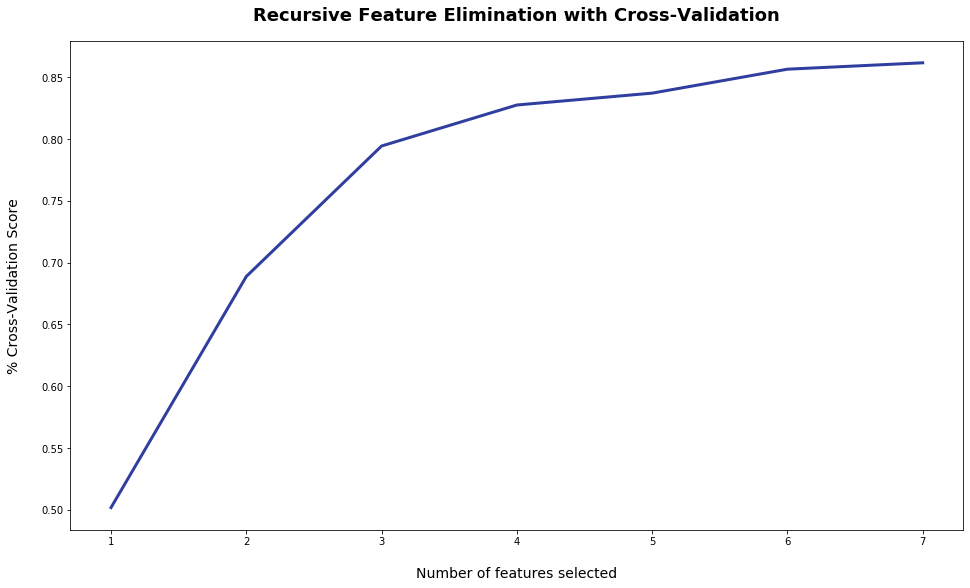

In [145]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Cross-Validation Score', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()


#### It is visible that with 7 features the scoring is about 85%, which is not bad.

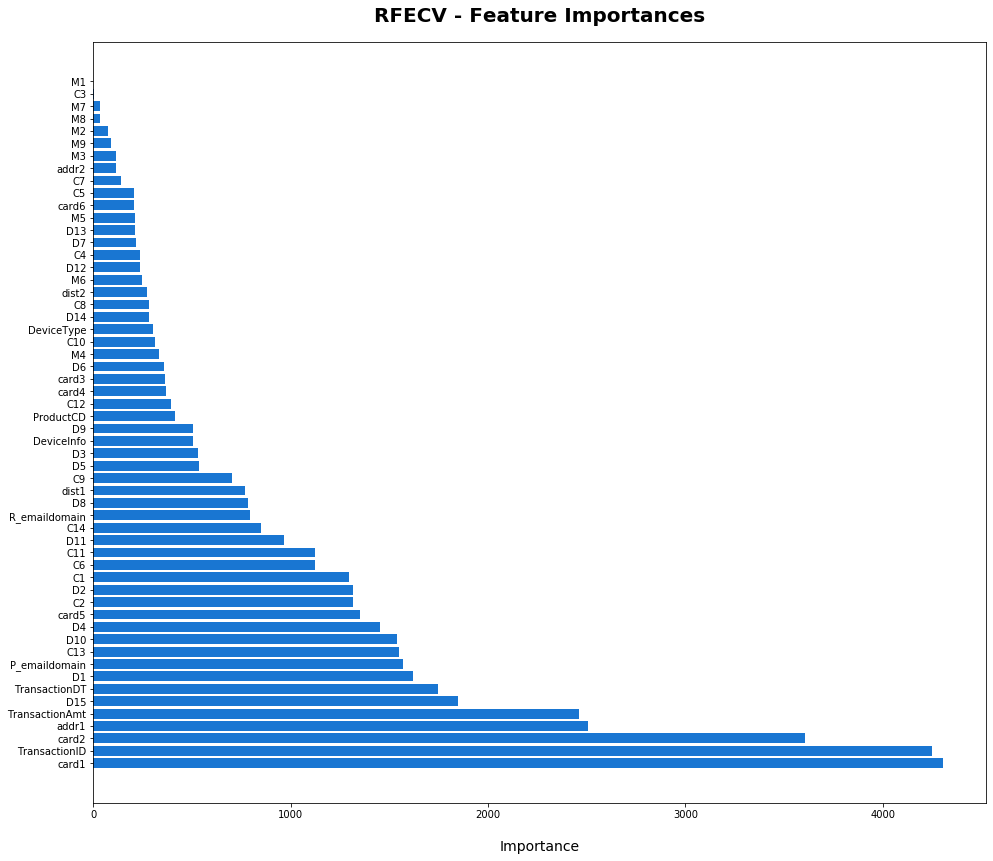

In [82]:
dset = pd.DataFrame()
dset['attr'] = X_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [97]:
print(X_train.columns[rfecv.ranking_ == 1].values) #Selected Features

['TransactionID' 'TransactionDT' 'TransactionAmt' 'ProductCD' 'card1'
 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1' 'dist2'
 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7'
 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3' 'M4' 'M5'
 'M6' 'M7' 'M8' 'M9' 'DeviceType' 'DeviceInfo']


In [98]:
print(X_train.columns[rfecv.ranking_ != 1].values) #Features to drop

[]


#### Recursive Feature Elimination selected 56 Optimal number of features out of 56 total features

### XGBoost Model

In [84]:
rfecv_xgb = RFECV(xgb.XGBClassifier(), step=10, scoring='roc_auc', cv=5, verbose=1)
rfecv_xgb.fit(X_train, y_train)

Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.
Fitting estimator with 6 features.
Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 featur

RFECV(cv=5,
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=1,
                              nthread=None, objective='binary:logistic',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=10,
      verbose=1)

In [85]:
print('Optimal number of features: {}'.format(rfecv_xgb.n_features_))

Optimal number of features: 56


In [94]:
print(X_train.columns[rfecv_xgb.ranking_ == 1].values) #Selected Features

['TransactionID' 'TransactionDT' 'TransactionAmt' 'ProductCD' 'card1'
 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1' 'dist2'
 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8'
 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7'
 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'M1' 'M2' 'M3' 'M4' 'M5'
 'M6' 'M7' 'M8' 'M9' 'DeviceType' 'DeviceInfo']


In [95]:
print(X_train.columns[rfecv_xgb.ranking_ != 1].values) #Features to drop

[]


### RandomForest Model

In [88]:
rfc = RandomForestClassifier()
rfecv_rf = RFECV(estimator=rfc, step=10, scoring='roc_auc', cv=5, verbose=1)
rfecv_rf.fit(X_train, y_train)

Fitting estimator with 56 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 46 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 36 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 26 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 16 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 6 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 56 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 46 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 36 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 26 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 16 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 6 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 56 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 46 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 36 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 26 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 16 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 6 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 56 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 46 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 36 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 26 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 16 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 6 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 56 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 46 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 36 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 26 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 16 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 6 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting estimator with 56 features.


/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/hs/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=10,
      verbose=1)

In [89]:
print('Optimal number of features: {}'.format(rfecv_rf.n_features_))

Optimal number of features: 46


In [92]:
print(X_train.columns[rfecv_rf.ranking_ == 1].values) #Selected Features

['TransactionID' 'TransactionDT' 'TransactionAmt' 'ProductCD' 'card1'
 'card2' 'card3' 'card4' 'card5' 'card6' 'addr1' 'addr2' 'dist1' 'dist2'
 'P_emaildomain' 'R_emaildomain' 'C1' 'C2' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9'
 'C10' 'C11' 'C12' 'C13' 'C14' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8'
 'D9' 'D10' 'D11' 'D12' 'D14' 'D15' 'M4' 'M6' 'DeviceInfo']


In [93]:
print(X_train.columns[rfecv_rf.ranking_ != 1].values) #Features to drop

['C3' 'D13' 'M1' 'M2' 'M3' 'M5' 'M7' 'M8' 'M9' 'DeviceType']


## BORUTA

#### BORUTA captures all the important and interesting features in dataset with respect to an outcome variable. Boruta find all relevant features useful for prediction, instead of defining a subset of features with minimal error. First of all BORUTA duplicates the dataset and shuffle the values (shadow features) in each column. Then it trains a classifier on the dataset. For the next step the algorithm checks for each real features if they have higher importance. After a predefined set of iterations, we will have a table of hits. At every iteration BORUTA compares the Z-scores (number of standard deviations from the mean a data point) of the shuffled copies of the features and the original features to see if the latter performed better than the former. If it does, the algorithm will mark the feature as important.  BORUTA is trying to validate the importance of the feature by comparing with random shuffled copies and this process is happening by simply comparing the number of times a feature did better with the shadow features using a binomial distribution. After a set number of iterations some features are either confirmed or rejected.

### RandomForest Model

In [99]:
rfc = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_selector = BorutaPy(rfc,  n_estimators=10, verbose=3, random_state=1)
boruta_selector.fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	56
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	34
Tentative: 	22
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	34
Tentative: 	22
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	34
Tentative: 	22
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	34
Tentative: 	21
Rejected: 	1
Iteration: 	12 / 100
Confirmed: 	38
Tentative: 	17
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	38
Tentative: 	17
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	38
Tentative: 	17
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	38
Tentative: 	16
Rejected: 	2
Iteration: 	16 / 100
Confirmed: 	40
Tentative: 	14
Rejec

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=5,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=10, n_jobs=-1,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7FCCEBB65570,
                                          verbose=0, warm_start=False),
         max_iter=100, n_e

In [100]:
#bootstrap >> Whether samples are drawn with replacement (default=True)
#class_weight >> "balanced" uses the values of y to automatically adjust weights
#criterion >> measures the quality of a split (default=”gini”) “entropy” for the information gain.
# Gini impurity measures probability of a variable being wrongly classified when it is randomly chosen. 
#max_depth >> Maximum tree depth for base learners.
#max_features >> maximum number of features (default='auto')
#max_leaf_nodes >> Total number of terminal nodes (leaves) in a tree (default=None)
#min_impurity_decrease >> gini-index or cross-entropy is used to calculate pureness of a split (default=0.0)
#min_impurity_split >> Threshold for early stopping in tree growth.
#min_samples_leaf >> minimum number of samples required to be at a leaf node (default=1)
#min_samples_split >> minimum number of samples required to split an internal node (default=2)
#min_weight_fraction_leaf >> min. weighted fraction of sum total of weights need to be at leaf node(default=0.0)
#n_estimators >> Number of boosted trees to fit (default='auto')
#n_jobs >> Number of parallel threas (default=-1)
#oob_score >> Whether to use out-of-bag samples to estimate the generalization accuracy (default=False)
#random_state >> Random number seed.
#verbose >> Requires at least one evaluation data. 
#warm_start >> reduce the computational time                          

In [101]:
print ('\n Initial features: ', X_train.columns.tolist() )

# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)


 Initial features:  ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo']

 Number of selected features:
46


In [102]:
feature_df = pd.DataFrame(X_train.columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))
feature_df.to_csv('boruta-feature-ranking.csv', index=False)

print ('\n Feature ranking:')
print (boruta_selector.ranking_)


 Top 46 features:
          features  rank
0    TransactionID     1
1              C11     1
2       DeviceType     1
3              C13     1
4              C14     1
5               D1     1
6               D2     1
7               D3     1
8               D4     1
9               D5     1
10              D6     1
11              D7     1
12              D8     1
13              D9     1
14             D10     1
15             D11     1
16             D12     1
17             D13     1
18             D14     1
19             D15     1
20              M4     1
21              M5     1
22             C10     1
23              C9     1
24             C12     1
25              C7     1
26   TransactionDT     1
27  TransactionAmt     1
28       ProductCD     1
29           card1     1
30           card2     1
31           card3     1
32              C8     1
33           card5     1
34           card6     1
35           addr1     1
36      DeviceInfo     1
37           dist1     1
38   P

In [103]:
# check selected features
selected_features = X_train.columns[boruta_selector.support_]
rejected_features = X_train.columns[boruta_selector.support_ == False]

print('List of selected features: \n', selected_features)
print('\nList of rejected features: \n', rejected_features)

List of selected features: 
 Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7',
       'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
       'M4', 'M5', 'DeviceType', 'DeviceInfo'],
      dtype='object')

List of rejected features: 
 Index(['card4', 'dist2', 'C3', 'M1', 'M2', 'M3', 'M6', 'M7', 'M8', 'M9'], dtype='object')


#### BORUTA selected 46 Optimal number of features out of 56 total features

### XGBoost & LGBM Models

#### ---> Boruta package for Python uses numpy.random.RandomState to seed models and not an integer, which works with sklearn models but conflicts with LightGBM and XGboost. Therefore, it's impossible to try Boruta with these models at the moment.

## Covariate Shift

#### Covariate shift refers to the change in the distribution of the input variables present in the training and the test data. It is the most common type of shift and it is now gaining more attention as nearly every real-world dataset suffers from this problem. Covariate shift occurs when the distribution of input variables is different between training and testing dataset. First of all, we need to add origin feature that tells us whether the observation belongs to training or testing dataset, then merge training and testing datasets. Next would be create a classification model taking examined feature as an explanatory variable and origin feature as a target on a part of merged dataset (75%), then predict on the rest of merged dataset (25%) and calculate ROC-AUC. If ROC-AUC is greater than a threshold, we identify the examined variable as drifting. As soon as we identified the drifting variables, we can drop them and continue with next steps in projects.

### LGBM model

In [104]:
# Creating a new feature origin
X_train['origin'] = 0
X_test['origin'] = 1

In [105]:
## Taking sample from training and test data
training = X_train.sample(10000, random_state=12)
testing = X_test.sample(10000, random_state=11)

In [106]:
# Combining random samples
combine = training.append(testing)
y = combine['origin']
combine.drop('origin',axis=1,inplace=True)

In [107]:
## Modeling

model = lgb.LGBMClassifier(**lgb_params)
drop_list = []
for i in combine.columns:
    score = cross_val_score(model,pd.DataFrame(combine[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.56):
        drop_list.append(i)
        print(i,np.mean(score))
       

TransactionID 0.99998288
TransactionDT 0.99998288
D10 0.5718101099999999
D11 0.62905776
D15 0.5927403900000001


In [108]:
# List   of   drifting   features 
len(drop_list)

5

In [109]:
#In order to drop features with covariate shift

drift_train = X_train.drop(drop_list, axis=1)

#These features remained after dropping

cols = drift_train.columns.tolist()
cols

['TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'DeviceType',
 'DeviceInfo',
 'origin']

#### Covariate Shift selected 50 Optimal number of features out of 56 total features

### XGBoost Model

In [110]:
## Modeling


xgb_model = xgb.XGBClassifier()
drop_list = []
for i in combine.columns:
    score = cross_val_score(xgb_model,pd.DataFrame(combine[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.56):
        drop_list.append(i)
        print(i,np.mean(score))

TransactionID 0.99995
TransactionDT 0.99995
D10 0.56863354
D11 0.6288224499999999
D15 0.59499703


### RandomForest Model

In [111]:
## Modeling

rf_model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in combine.columns:
    score = cross_val_score(rf_model,pd.DataFrame(combine[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.56):
        drop_list.append(i)
        print(i,np.mean(score))

TransactionID 1.0
TransactionDT 1.0
D4 0.56183917
D10 0.57169421
D11 0.6305787300000001
D15 0.5961828599999999


## Prediction after Recursive Feature Elimination

#### Training the LGBM and XGBoost models (all features)

In [112]:
# Recursive Feature Elimination with LGBM and XGBoost
train_recur  = X_train.drop(columns = ['origin'], axis = 1)
test_recur = X_test.drop(columns = ['origin'], axis = 1)

In [113]:
lgb_train_rec = lgb.Dataset(train_recur, y_train)
lgb_eval_rec = lgb.Dataset(test_recur, y_test)
lgb_rec = lgb.train(lgb_params,lgb_train_rec,num_boost_round=20,valid_sets=lgb_eval_rec,early_stopping_rounds=5)

[1]	valid_0's auc: 0.836946
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.855477
[3]	valid_0's auc: 0.85841
[4]	valid_0's auc: 0.870191
[5]	valid_0's auc: 0.871834
[6]	valid_0's auc: 0.873132
[7]	valid_0's auc: 0.878352
[8]	valid_0's auc: 0.880014
[9]	valid_0's auc: 0.883295
[10]	valid_0's auc: 0.885412
[11]	valid_0's auc: 0.887709
[12]	valid_0's auc: 0.887834
[13]	valid_0's auc: 0.889406
[14]	valid_0's auc: 0.889186
[15]	valid_0's auc: 0.889482
[16]	valid_0's auc: 0.890227
[17]	valid_0's auc: 0.890733
[18]	valid_0's auc: 0.890039
[19]	valid_0's auc: 0.889836
[20]	valid_0's auc: 0.890618
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.890733


In [114]:
bst_recur = lgb.train(lgb_params, lgb_train_rec, 100)
scores_recur = bst_recur.predict(test_recur)
y_pred_recur = 1*(scores_recur<np.percentile(scores_recur, 100*conta))
res_recur = getMetrics(y_test, scores_recur, y_pred_recur)
print(res_recur)

# 1. true classif rate, 
# 2. true positive rate, 
# 3. true negative rate, 
# 4. area under roc curve, 
# 5. area under precision recall curve,
# 6. f1 - score,
# 7. matthew corr coef.

(0.9303558483992773, 0.002178649237472767, 0.9637837110767369, 0.9016808348395715, 0.5204763312203946, 0.002170206169586111, -0.03391073756225035)


In [115]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_rec.predict (test_recur), n=100)

0.97

In [116]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_rec.predict (test_recur), n=50)

0.98

In [117]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_rec.predict (test_recur), n=10)

1.0

#### As we can see the area under roc curve is 0.90 and prediction precision rank is 0.97

#### Training the RandomForest model

In [132]:
# Recursive Feature Elimination with RandomForest
train_rec_rf  = X_train.drop(columns = ['C3','D13', 'M1', 'M2', 'M3', 'M5', 'M7', 'M8', 'M9', 'DeviceType','origin'], axis = 1)
test_rec_rf = X_test.drop(columns = ['C3','D13', 'M1', 'M2', 'M3', 'M5', 'M7', 'M8', 'M9', 'DeviceType','origin'], axis = 1)

In [133]:
lgb_train_rec_rf = lgb.Dataset(train_rec_rf, y_train)
lgb_eval_rec_rf = lgb.Dataset(test_rec_rf, y_test)
lgb_rec_rf = lgb.train(lgb_params,lgb_train_rec_rf,num_boost_round=20,valid_sets=lgb_eval_rec_rf,early_stopping_rounds=5)

[1]	valid_0's auc: 0.838191
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.862544
[3]	valid_0's auc: 0.864293
[4]	valid_0's auc: 0.869502
[5]	valid_0's auc: 0.873397
[6]	valid_0's auc: 0.87595
[7]	valid_0's auc: 0.875934
[8]	valid_0's auc: 0.876872
[9]	valid_0's auc: 0.877236
[10]	valid_0's auc: 0.878535
[11]	valid_0's auc: 0.878019
[12]	valid_0's auc: 0.878894
[13]	valid_0's auc: 0.878986
[14]	valid_0's auc: 0.880061
[15]	valid_0's auc: 0.881553
[16]	valid_0's auc: 0.881471
[17]	valid_0's auc: 0.882382
[18]	valid_0's auc: 0.883291
[19]	valid_0's auc: 0.883676
[20]	valid_0's auc: 0.882935
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.883676


In [134]:
bst_rec_rf = lgb.train(lgb_params, lgb_train_rec_rf, 100)
scores_rec_rf = bst_rec_rf.predict(test_rec_rf)
y_pred_rec_rf = 1*(scores_rec_rf<np.percentile(scores_rec_rf, 100*conta))
res_rec_rf = getMetrics(y_test, scores_rec_rf, y_pred_rec_rf)
print(res_rec_rf)

# 1. true classif rate, 
# 2. true positive rate, 
# 3. true negative rate, 
# 4. area under roc curve, 
# 5. area under precision recall curve,
# 6. f1 - score,
# 7. matthew corr coef.

(0.93031257100198, 0.001556178026766262, 0.9637612930705943, 0.8994636710070453, 0.5195552085302043, 0.0015501472639900791, -0.0345532224463718)


In [135]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_rec_rf.predict (test_rec_rf), n=100)

0.97

In [136]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_rec_rf.predict (test_rec_rf), n=50)

1.0

In [137]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_rec_rf.predict (test_rec_rf), n=10)

1.0

## Prediction after Boruta

In [118]:
# BORUTA with RandomForest
train_boruta  = X_train.drop(columns = ['card4', 'dist2', 'C3', 'M1', 'M2', 'M3', 'M6', 'M7', 'M8', 'M9', 'origin'], axis = 1)
test_boruta = X_test.drop(columns = ['card4', 'dist2', 'C3', 'M1', 'M2', 'M3', 'M6', 'M7', 'M8', 'M9', 'origin'], axis = 1)

In [119]:
lgb_train_bor = lgb.Dataset(train_boruta, y_train)
lgb_eval_bor = lgb.Dataset(test_boruta, y_test)
lgb_bor = lgb.train(lgb_params,lgb_train_bor,num_boost_round=20,valid_sets=lgb_eval_bor,early_stopping_rounds=5)

[1]	valid_0's auc: 0.815173
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.844091
[3]	valid_0's auc: 0.852196
[4]	valid_0's auc: 0.854054
[5]	valid_0's auc: 0.860318
[6]	valid_0's auc: 0.862722
[7]	valid_0's auc: 0.867457
[8]	valid_0's auc: 0.870441
[9]	valid_0's auc: 0.872194
[10]	valid_0's auc: 0.873991
[11]	valid_0's auc: 0.877737
[12]	valid_0's auc: 0.879786
[13]	valid_0's auc: 0.880631
[14]	valid_0's auc: 0.881345
[15]	valid_0's auc: 0.883249
[16]	valid_0's auc: 0.88239
[17]	valid_0's auc: 0.882779
[18]	valid_0's auc: 0.883393
[19]	valid_0's auc: 0.883913
[20]	valid_0's auc: 0.883886
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.883913


In [120]:
bst_boruta = lgb.train(lgb_params, lgb_train_bor, 100)
scores_boruta = bst_boruta.predict(test_boruta)
y_pred_boruta = 1*(scores_boruta<np.percentile(scores_boruta, 100*conta))
res_boruta = getMetrics(y_test, scores_boruta, y_pred_boruta)
print(res_boruta)

# 1. true classif rate, 
# 2. true positive rate, 
# 3. true negative rate, 
# 4. area under roc curve, 
# 5. area under precision recall curve,
# 6. f1 - score,
# 7. matthew corr coef.

(0.9303991257965746, 0.0028011204481792717, 0.9638061290828793, 0.8977255638482642, 0.5157148200995851, 0.0027902650751821423, -0.03326825267812889)


In [121]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_bor.predict (test_boruta), n=100)

1.0

In [122]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_bor.predict (test_boruta), n=50)

1.0

In [123]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_bor.predict (test_boruta), n=10)

1.0

#### As we can see the area under roc curve is 0.897 and prediction precision rank is 1.

## Prediction after Covariate Shift

In [124]:
# Covariate Shift with LGBM and XGBoost

train_covar  = X_train.drop(columns = ['TransactionID', 'TransactionDT','D10', 'D11', 'D15', 'origin'], axis = 1)
test_covar = X_test.drop(columns = ['TransactionID', 'TransactionDT', 'D10', 'D11', 'D15', 'origin'], axis = 1)

In [125]:
lgb_train_cov = lgb.Dataset(train_covar, y_train)
lgb_eval_cov = lgb.Dataset(test_covar, y_test)
lgb_cov = lgb.train(lgb_params,lgb_train_cov,num_boost_round=20,valid_sets=lgb_eval_cov,early_stopping_rounds=5)

[1]	valid_0's auc: 0.826981
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.846862
[3]	valid_0's auc: 0.861262
[4]	valid_0's auc: 0.865061
[5]	valid_0's auc: 0.86879
[6]	valid_0's auc: 0.874794
[7]	valid_0's auc: 0.875724
[8]	valid_0's auc: 0.878455
[9]	valid_0's auc: 0.880833
[10]	valid_0's auc: 0.88266
[11]	valid_0's auc: 0.882793
[12]	valid_0's auc: 0.88588
[13]	valid_0's auc: 0.887392
[14]	valid_0's auc: 0.887877
[15]	valid_0's auc: 0.887843
[16]	valid_0's auc: 0.888385
[17]	valid_0's auc: 0.889875
[18]	valid_0's auc: 0.889771
[19]	valid_0's auc: 0.890213
[20]	valid_0's auc: 0.890716
Did not meet early stopping. Best iteration is:
[20]	valid_0's auc: 0.890716


In [126]:
bst_cov = lgb.train(lgb_params, lgb_train_cov, 100)
scores_cov = bst_cov.predict(test_covar)
y_pred_cov = 1*(scores_cov<np.percentile(scores_cov, 100*conta))
res_cov = getMetrics(y_test, scores_cov, y_pred_cov)
print(res_cov)

# 1. true classif rate, 
# 2. true positive rate, 
# 3. true negative rate, 
# 4. area under roc curve, 
# 5. area under precision recall curve,
# 6. f1 - score,
# 7. matthew corr coef.

(0.9302692936046826, 0.0009337068160597573, 0.9637388750644518, 0.8995179542587691, 0.5232151175265305, 0.0009300883583940474, -0.03519570733049326)


In [127]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_cov.predict (test_covar), n=100)

0.99

In [128]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_cov.predict (test_covar), n=50)

1.0

In [129]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_cov.predict (test_covar), n=10)

1.0

#### As we can see the area under roc curve is 0.899 and prediction precision rank is 0.99

In [138]:
# Covariate Shift with Random Forest

train_cov_rf  = X_train.drop(columns = ['TransactionID', 'TransactionDT','D10', 'D11', 'D15', 'D4', 'origin'], axis = 1)
test_cov_rf = X_test.drop(columns = ['TransactionID', 'TransactionDT', 'D10', 'D11', 'D15', 'D4','origin'], axis = 1)

In [139]:
lgb_train_cov_rf = lgb.Dataset(train_cov_rf, y_train)
lgb_eval_cov_rf = lgb.Dataset(test_cov_rf, y_test)
lgb_cov_rf = lgb.train(lgb_params,lgb_train_cov_rf,num_boost_round=20,valid_sets=lgb_eval_cov_rf,early_stopping_rounds=5)

[1]	valid_0's auc: 0.831665
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.851451
[3]	valid_0's auc: 0.865702
[4]	valid_0's auc: 0.868117
[5]	valid_0's auc: 0.87254
[6]	valid_0's auc: 0.876306
[7]	valid_0's auc: 0.876504
[8]	valid_0's auc: 0.87827
[9]	valid_0's auc: 0.87933
[10]	valid_0's auc: 0.881089
[11]	valid_0's auc: 0.881119
[12]	valid_0's auc: 0.881084
[13]	valid_0's auc: 0.881587
[14]	valid_0's auc: 0.882815
[15]	valid_0's auc: 0.884338
[16]	valid_0's auc: 0.885444
[17]	valid_0's auc: 0.886992
[18]	valid_0's auc: 0.886878
[19]	valid_0's auc: 0.887561
[20]	valid_0's auc: 0.887521
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.887561


In [140]:
bst_cov_rf = lgb.train(lgb_params, lgb_train_cov_rf, 100)
scores_cov_rf = bst_cov_rf.predict(test_cov_rf)
y_pred_cov_rf = 1*(scores_cov<np.percentile(scores_cov_rf, 100*conta))
res_cov_rf = getMetrics(y_test, scores_cov_rf, y_pred_cov_rf)
print(res_cov_rf)

# 1. true classif rate, 
# 2. true positive rate, 
# 3. true negative rate, 
# 4. area under roc curve, 
# 5. area under precision recall curve,
# 6. f1 - score,
# 7. matthew corr coef.

(0.919287654040486, 0.0009337068160597573, 0.9523617369471159, 0.9004280133227845, 0.52330834986686, 0.0008036431824270025, -0.04083317555250046)


In [141]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_cov_rf.predict (test_cov_rf), n=100)

0.97

In [142]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_cov_rf.predict (test_cov_rf), n=50)

1.0

In [143]:
#Evaluate the prediction Precision rank 
precision_n_scores(y_test, lgb_cov_rf.predict (test_cov_rf), n=10)

1.0

## Results 

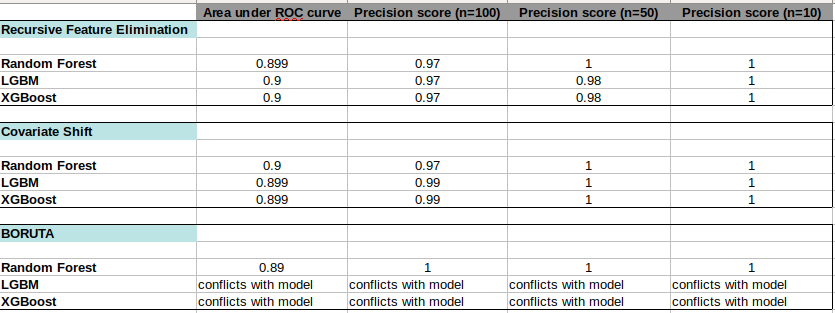

In [147]:
from IPython.display import Image
Image("../data/Models.png")

## References

1. Recursive Feature Elimination https://bookdown.org/max/FES/recursive-feature-elimination.html 

2. Covariate Shift Adaptation by Importance Weighted Cross Validation http://www.jmlr.org/papers/volume8/sugiyama07a/sugiyama07a.pdf

3. Feature Selection with the Boruta Package https://www.jstatsoft.org/article/view/v036i11  

4. Covariate Shift in Machine Learning https://dkopczyk.quantee.co.uk/covariate_shift/

5. The 5 Feature Selection Algorithms every Data Scientist should know https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2